In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import pytz

In [2]:
start_time = datetime(2014, 12, 31, 23, 59, 0)

In [48]:
twr = yf.Ticker('TWR.NZ')
twr.history(period='10y')

$TWR.NZ: possibly delisted; no price data found  (period=10y)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [3]:
COMPANIES_FILE_PATH = 'nz_main_board_companies.csv'
STOCK_FILE_PATH = 'nz_main_stock_data.csv'
START_TIME = pytz.timezone('Pacific/Auckland').localize((start_time))
KEY_COLS = ['close','dividends', 'company', 'sector', 'industry']
PERIOD = '10y'
Z_SCORE_THRESHOLD = 2


In [4]:
nz_main_board_companies = pd.read_csv(COMPANIES_FILE_PATH)
nz_main_board_companies.head()

,Code,Company
0,WIN,Winton Land Limited (NS)
1,WHS,The Warehouse Group Limited
2,WCO,WasteCo Group Limited
3,WBC,Westpac Banking Corporation
4,VTL,Vital Limited


In [5]:
def get_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    stock_df = pd.DataFrame()
    
    for _, (code, company) in df.iterrows():
        ticker = yf.Ticker(f"{code}.NZ")
        
        cur_stock_df = ticker.history(period=PERIOD)
        
        info = ticker.info
        
        if cur_stock_df.empty:
            continue
        
        cur_stock_df['company'] = company
        cur_stock_df['sector'] = info.get('sector')
        cur_stock_df['industry'] = info.get('industry')
        
        stock_df = pd.concat([stock_df, cur_stock_df]) 
    
    return stock_df 

In [6]:
stock_df = pd.DataFrame()  

try:
    if os.path.exists(STOCK_FILE_PATH):
        stock_df = pd.read_csv(STOCK_FILE_PATH, index_col='Date')
        print(f"Data successfully loaded from {STOCK_FILE_PATH}.")
    else:
        raise FileNotFoundError(f"{STOCK_FILE_PATH} does not exist.")
except FileNotFoundError as fnf_error:
    # If file is not found, gather the data and save it
    print(fnf_error)
    print("Generating new stocks data from source.")
    stock_df = get_stock_data(nz_main_board_companies)
    stock_df.to_csv(STOCK_FILE_PATH, index=True)
    print(f"Data successfully saved to {STOCK_FILE_PATH}.")
except pd.errors.ParserError as parse_error:
    # Handle parsing errors specifically
    print(f"Parsing error occurred: {parse_error}")
except Exception as e:
    # General exception handling for unforeseen errors
    print(f"An error occurred: {e}")

Data successfully loaded from nz_main_stock_data.csv.


In [7]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370329 entries, 2021-12-17 00:00:00+13:00 to 2025-05-02 00:00:00+12:00
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Open           370276 non-null  float64
 1   High           370276 non-null  float64
 2   Low            370276 non-null  float64
 3   Close          370276 non-null  float64
 4   Volume         370329 non-null  int64  
 5   Dividends      370329 non-null  float64
 6   Stock Splits   370329 non-null  float64
 7   company        370329 non-null  object 
 8   sector         274829 non-null  object 
 9   industry       274829 non-null  object 
 10  Capital Gains  5017 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 33.9+ MB


In [8]:
stock_df.columns = stock_df.columns.str.lower()
stock_df = stock_df[KEY_COLS]

stock_df['close_ffill'] = stock_df['close'].ffill()
dividends_df = stock_df[stock_df['dividends'] > 0].copy()
dividends_df['close'] = dividends_df['close'].combine_first(dividends_df['close_ffill'])
dividends_df.drop('close_ffill', axis=1, inplace=True)

dividends_df.index = pd.to_datetime(dividends_df.index, utc=True).tz_convert('Pacific/Auckland')
dividends_df['year'] = dividends_df.index.year

dividends_df

,close,dividends,company,sector,industry,year
Date,,,,,,
2022-08-30 00:00:00+12:00,2.541574,0.010700,Winton Land Limited (NS),Real Estate,Real Estate - Development,2022
2023-02-28 00:00:00+13:00,1.916445,0.020600,Winton Land Limited (NS),Real Estate,Real Estate - Development,2023
2023-08-28 00:00:00+12:00,2.342819,0.021600,Winton Land Limited (NS),Real Estate,Real Estate - Development,2023
2024-02-26 00:00:00+13:00,2.500000,0.007639,Winton Land Limited (NS),Real Estate,Real Estate - Development,2024
2015-11-25 00:00:00+13:00,1.487685,0.050000,The Warehouse Group Limited,Consumer Cyclical,Department Stores,2015
...,...,...,...,...,...,...
2024-08-14 00:00:00+12:00,6.808300,0.157600,Australian Foundation Investment Company Limited,Financial Services,Asset Management,2024
2025-02-03 00:00:00+13:00,6.940000,0.131700,Australian Foundation Investment Company Limited,Financial Services,Asset Management,2025
2023-11-21 00:00:00+13:00,0.769250,0.041600,2 Cheap Cars Group Limited,Consumer Cyclical,Auto & Truck Dealerships,2023


In [9]:
dividends_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2343 entries, 2022-08-30 00:00:00+12:00 to 2024-11-21 00:00:00+13:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   close      2343 non-null   float64
 1   dividends  2343 non-null   float64
 2   company    2343 non-null   object 
 3   sector     1452 non-null   object 
 4   industry   1452 non-null   object 
 5   year       2343 non-null   int32  
dtypes: float64(2), int32(1), object(3)
memory usage: 119.0+ KB


In [10]:
dividends_df['sector'].unique()

array(['Real Estate', 'Consumer Cyclical', 'Financial Services',
       'Communication Services', 'Basic Materials', 'Industrials',
       'Technology', 'Utilities', nan, 'Consumer Defensive', 'Healthcare',
       'Energy'], dtype=object)

In [11]:
dividends_df['industry'].unique()

array(['Real Estate - Development', 'Department Stores',
       'Banks - Diversified', 'Telecom Services', 'Steel',
       'Infrastructure Operations', 'REIT - Healthcare Facilities',
       'Software - Application', 'Utilities - Diversified', nan,
       'Insurance - Property & Casualty', 'Auto & Truck Dealerships',
       'Recreational Vehicles', 'Farm Products',
       'Medical Care Facilities', 'Marine Shipping',
       'Real Estate Services', 'Entertainment',
       'Specialty Industrial Machinery', 'Resorts & Casinos',
       'Packaged Foods', 'Restaurants', 'Electrical Equipment & Parts',
       'Specialty Business Services', 'REIT - Industrial',
       'REIT - Diversified', 'Financial Data & Stock Exchanges',
       'Utilities - Regulated Electric', 'Building Products & Equipment',
       'Integrated Freight & Logistics', 'Utilities - Renewable',
       'Luxury Goods', 'Internet Retail', 'Lodging',
       'Apparel Manufacturing', 'REIT - Retail', 'Conglomerates',
       'Appare

In [12]:
companies = dividends_df['company'].unique()
unique_sectors = [x for x in dividends_df['sector'].unique() if pd.notnull(x)]
unique_industries = [x for x in dividends_df['industry'].unique() if pd.notnull(x)]
companies_without_sector = dividends_df[dividends_df['sector'].isna()]['company'].unique()
companies_without_industry = dividends_df[dividends_df['industry'].isna()]['company'].unique(),

In [13]:
company_cnt = len(companies)
sector_cnt = len(unique_sectors)
industry_cnt = len(unique_industries)
no_sector_cnt = max(len(companies_without_sector), 
                    len(companies_without_industry))

print(f"{company_cnt} companies issued dividends over the past ten years, and they belong to {sector_cnt} sectors and {industry_cnt} industries.\nThere are also {no_sector_cnt} companies without any information on sector or industry.")

140 companies issued dividends over the past ten years, and they belong to 11 sectors and 51 industries.
There are also 48 companies without any information on sector or industry.


In [14]:
print(f"The following companies do not have sector information: {companies_without_sector}.\n")

print(f"The following companies do not have industry information: {companies_without_industry}.")

The following companies do not have sector information: ['Smart US Large Value ETF' 'Smart US Small Cap ETF'
 'Smart US Mid Cap ETF' 'Smart US 500 (NZD Hedged) ETF'
 'Smart US Large Growth ETF' 'Smart US 500 ETF' 'Smart US ESG ETF'
 'Smart Total World (NZD Hedged) ETF' 'Smart Total World ETF'
 'Smart NZ Top 10 ETF' 'Templeton Emerging Markets Investment Trust Plc'
 'Private Land and Property Fund' 'Smart Australian Top 20 ETF'
 'Smart S&P/NZX 50 ETF' 'Smart NZ Cash ETF' 'Smart NZ Bond ETF'
 'Smart NZ Property ETF' 'Smart S&P/NZX NZ Government Bond ETF'
 'Smart Australian Mid Cap ETF' 'Marlin Global Limited'
 'Smart NZ Mid Cap ETF' 'Smart Healthcare Innovation ETF'
 'Kingfish Limited' 'Smart Japan ESG ETF'
 'Smart Global Infrastructure ETF' 'Henderson Far East Income Limited'
 'Smart Global Property ETF' 'Smart Global Government Bond ETF'
 'Smart Global Bond ETF' 'Smart NZ Top 50 ETF' 'F&C Investment Trust PLC'
 'Smart Europe ESG ETF' 'Smart Europe ETF' 'Smart Global ESG ETF'
 'Smart Em

In [15]:
companies_without_sector == companies_without_industry

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])

In [16]:
sector_dict = {
    'Templeton Emerging Markets Investment Trust Plc': 'Financial Services',
    'Private Land and Property Fund':'Real Estate',
    'Marlin Global Limited': 'Financial Services',
    'Kingfish Limited': 'Financial Services',
    'Henderson Far East Income Limited': 'Financial Services',
    'F&C Investment Trust PLC': 'Financial Services',
    'Downer EDI Limited': 'Industrials',
    'Barramundi Limited': 'Financial Services',
    'The Bankers Investment Trust Plc':'Financial Services'
}

industry_dict = {
    'Templeton Emerging Markets Investment Trust Plc': 'Asset Management',
    'Private Land and Property Fund': 'Real Estate - Speciality',
    'Marlin Global Limited': 'Asset Management',
    'Kingfish Limited': 'Asset Management',
    'Henderson Far East Income Limited': 'Asset Management',
    'F&C Investment Trust PLC': 'Asset Management',
    'Downer EDI Limited': 'Engineering & Construction',
    'Barramundi Limited': 'Asset Management',
    'The Bankers Investment Trust Plc': 'Asset Management'
}

In [17]:
dividends_df['sector'] = dividends_df['company'].map(sector_dict).fillna(dividends_df['sector'])
dividends_df['industry'] = dividends_df['company'].map(industry_dict).fillna(dividends_df['industry'])

In [18]:
dividends_df['dividend_yield'] = dividends_df['dividends'].div(dividends_df['close'], axis=0)

In [19]:
non_etf_dividends_df = dividends_df[~dividends_df['company'].str.contains('ETF')]
non_etf_dividends_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1738 entries, 2022-08-30 00:00:00+12:00 to 2024-11-21 00:00:00+13:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   close           1738 non-null   float64
 1   dividends       1738 non-null   float64
 2   company         1738 non-null   object 
 3   sector          1738 non-null   object 
 4   industry        1738 non-null   object 
 5   year            1738 non-null   int32  
 6   dividend_yield  1738 non-null   float64
dtypes: float64(3), int32(1), object(3)
memory usage: 101.8+ KB


In [20]:
non_etf_dividends_df.head()

,close,dividends,company,sector,industry,year,dividend_yield
Date,,,,,,,
2022-08-30 00:00:00+12:00,2.541574,0.010700,Winton Land Limited (NS),Real Estate,Real Estate - Development,2022,0.004210
2023-02-28 00:00:00+13:00,1.916445,0.020600,Winton Land Limited (NS),Real Estate,Real Estate - Development,2023,0.010749
2023-08-28 00:00:00+12:00,2.342819,0.021600,Winton Land Limited (NS),Real Estate,Real Estate - Development,2023,0.009220
2024-02-26 00:00:00+13:00,2.500000,0.007639,Winton Land Limited (NS),Real Estate,Real Estate - Development,2024,0.003056
2015-11-25 00:00:00+13:00,1.487685,0.050000,The Warehouse Group Limited,Consumer Cyclical,Department Stores,2015,0.033609


In [21]:
non_etf_dividends_df.groupby('sector')['company'].nunique()

sector
Basic Materials            3
Communication Services     5
Consumer Cyclical         14
Consumer Defensive        13
Energy                     1
Financial Services        14
Healthcare                 9
Industrials               18
Real Estate               13
Technology                 4
Utilities                  7
Name: company, dtype: int64

In [22]:
non_etf_dividends_df[non_etf_dividends_df['sector'] == 'Basic Materials']

,close,dividends,company,sector,industry,year,dividend_yield
Date,,,,,,,
2022-03-10 00:00:00+13:00,7.820786,0.323529,Vulcan Steel Limited,Basic Materials,Steel,2022,0.041368
2022-09-20 00:00:00+12:00,7.013064,0.427900,Vulcan Steel Limited,Basic Materials,Steel,2022,0.061015
2022-09-22 00:00:00+12:00,7.465656,0.375000,Vulcan Steel Limited,Basic Materials,Steel,2022,0.050230
2023-03-09 00:00:00+13:00,8.245689,0.288235,Vulcan Steel Limited,Basic Materials,Steel,2023,0.034956
2023-09-27 00:00:00+13:00,7.758816,0.328682,Vulcan Steel Limited,Basic Materials,Steel,2023,0.042362
2024-02-29 00:00:00+13:00,8.150040,0.141176,Vulcan Steel Limited,Basic Materials,Steel,2024,0.017322
2024-09-26 00:00:00+12:00,8.205516,0.126400,Vulcan Steel Limited,Basic Materials,Steel,2024,0.015404
2025-03-13 00:00:00+13:00,8.770000,0.025882,Vulcan Steel Limited,Basic Materials,Steel,2025,0.002951
2015-09-23 00:00:00+12:00,1.447967,0.017963,Steel & Tube Holdings Limited,Basic Materials,Steel,2015,0.012406


In [23]:
non_etf_dividends_df[non_etf_dividends_df['sector'] == 'Energy']

,close,dividends,company,sector,industry,year,dividend_yield
Date,,,,,,,
2016-03-09 00:00:00+13:00,2.943734,0.198458,Channel Infrastructure NZ Limited,Energy,Oil & Gas Refining & Marketing,2016,0.067417
2018-09-12 00:00:00+12:00,2.299199,0.029769,Channel Infrastructure NZ Limited,Energy,Oil & Gas Refining & Marketing,2018,0.012948
2019-03-06 00:00:00+13:00,1.878878,0.044653,Channel Infrastructure NZ Limited,Energy,Oil & Gas Refining & Marketing,2019,0.023766
2019-09-11 00:00:00+12:00,1.980632,0.019846,Channel Infrastructure NZ Limited,Energy,Oil & Gas Refining & Marketing,2019,0.010020
2023-03-09 00:00:00+13:00,1.392000,0.049615,Channel Infrastructure NZ Limited,Energy,Oil & Gas Refining & Marketing,2023,0.035643
2025-03-12 00:00:00+13:00,1.950000,0.066000,Channel Infrastructure NZ Limited,Energy,Oil & Gas Refining & Marketing,2025,0.033846


In [24]:
non_etf_dividends_df[non_etf_dividends_df['sector'] == 'Technology']

,close,dividends,company,sector,industry,year,dividend_yield
Date,,,,,,,
2017-03-09 00:00:00+13:00,2.583124,0.021977,Vista Group International Limited,Technology,Software - Application,2017,0.008508
2017-09-07 00:00:00+12:00,2.538454,0.011441,Vista Group International Limited,Technology,Software - Application,2017,0.004507
2018-03-09 00:00:00+13:00,2.545461,0.016561,Vista Group International Limited,Technology,Software - Application,2018,0.006506
2018-09-12 00:00:00+12:00,3.776473,0.015255,Vista Group International Limited,Technology,Software - Application,2018,0.004039
2019-03-08 00:00:00+13:00,4.467782,0.020022,Vista Group International Limited,Technology,Software - Application,2019,0.004481
2019-09-12 00:00:00+12:00,3.804246,0.011441,Vista Group International Limited,Technology,Software - Application,2019,0.003007
2015-09-23 00:00:00+12:00,0.759545,0.015000,Solution Dynamics Limited,Technology,Software - Application,2015,0.019749
2016-02-26 00:00:00+13:00,1.194930,0.030000,Solution Dynamics Limited,Technology,Software - Application,2016,0.025106
2016-08-22 00:00:00+12:00,1.674811,0.022500,Solution Dynamics Limited,Technology,Software - Application,2016,0.013434


In [25]:
non_etf_dividends_df = non_etf_dividends_df[~non_etf_dividends_df['sector'].isin(['Energy', 'Basic Materials'])]

In [26]:
annual_dividend_yield = non_etf_dividends_df.groupby(['company', 'year']).apply(
    lambda g: pd.Series({
        'annual_dividend': g['dividends'].sum(),
        'avg_price': g['close'].mean(),
        'sector': g['sector'].iloc[0]
    })
).reset_index()

# Compute annualized dividend yield
annual_dividend_yield['annual_yield'] = annual_dividend_yield['annual_dividend'] / annual_dividend_yield['avg_price']
annual_dividend_yield

C:\Users\jyang691\AppData\Local\Temp\ipykernel_27400\2752375087.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_dividend_yield = non_etf_dividends_df.groupby(['company', 'year']).apply(


,company,year,annual_dividend,avg_price,sector,annual_yield
0,2 Cheap Cars Group Limited,2023,0.041600,0.769250,Consumer Cyclical,0.054079
1,2 Cheap Cars Group Limited,2024,0.074823,0.831586,Consumer Cyclical,0.089976
2,AFT Pharmaceuticals Limited,2023,0.011000,3.471987,Healthcare,0.003168
3,AFT Pharmaceuticals Limited,2024,0.016000,3.100000,Healthcare,0.005161
4,ANZ Group Holdings Limited,2015,1.942656,19.302325,Financial Services,0.100644
...,...,...,...,...,...,...
795,Westpac Banking Corporation,2023,1.538286,21.356007,Financial Services,0.072031
796,Westpac Banking Corporation,2024,1.635783,31.486190,Financial Services,0.051952
797,Winton Land Limited (NS),2022,0.010700,2.541574,Real Estate,0.004210
798,Winton Land Limited (NS),2023,0.042200,2.129632,Real Estate,0.019816


In [27]:
# Step 3: Identify outliers per sector-year
def detect_outliers(subdf):
    # Use IQR method (can be replaced with z-score if preferred)
    grp_mean = subdf['annual_yield'].mean()
    grp_std = subdf['annual_yield'].std()
    subdf['z_score'] = np.abs(subdf['annual_yield'] - grp_mean) / grp_std
    mask =  subdf['z_score'] > 2
    outliers = subdf[mask]
    clean = subdf[~mask]
    return clean, outliers

In [28]:

clean_list = []
outlier_list = []
for (sector, year), group in annual_dividend_yield.groupby(['sector', 'year']):
    clean, outliers = detect_outliers(group)
    if not clean.empty:
        clean_list.append(clean)
    if not outliers.empty:
        outlier_list.append(outliers)

# Combine the results
annual_yield_no_outliers = pd.concat(clean_list).reset_index(drop=True)
outliers_df = pd.concat(outlier_list).reset_index(drop=True)

In [29]:
outliers_df

,company,year,annual_dividend,avg_price,sector,annual_yield,z_score
0,Hallenstein Glasson Holdings Limited,2015,0.165000,1.607846,Consumer Cyclical,0.102622,2.162878
1,Hallenstein Glasson Holdings Limited,2016,0.300000,1.512193,Consumer Cyclical,0.198387,2.668901
2,Hallenstein Glasson Holdings Limited,2017,0.315000,1.916094,Consumer Cyclical,0.164397,2.438512
3,Hallenstein Glasson Holdings Limited,2018,0.440000,2.943387,Consumer Cyclical,0.149488,2.215836
4,Hallenstein Glasson Holdings Limited,2019,0.440000,3.508978,Consumer Cyclical,0.125393,2.080710
5,My Food Bag Group Limited,2022,0.085556,0.579993,Consumer Cyclical,0.147512,2.355665
6,Burger Fuel Group Limited,2024,0.270000,0.350000,Consumer Cyclical,0.771429,3.312248
7,Livestock Improvement Corporation Limited (NS),2015,0.050659,0.411737,Consumer Defensive,0.123037,2.275517
8,Fonterra Shareholders' Fund (NS),2017,0.400000,2.761268,Consumer Defensive,0.144861,2.233386
9,Livestock Improvement Corporation Limited (NS),2019,0.109760,0.410501,Consumer Defensive,0.267380,2.430772


In [30]:
pd.set_option('display.max_rows', 150)
annual_dividend_yield[annual_dividend_yield['sector'] == 'Industrials']

,company,year,annual_dividend,avg_price,sector,annual_yield
14,Accordant Group Limited,2015,0.152000,1.437156,Industrials,0.105764
15,Accordant Group Limited,2016,0.160000,1.559674,Industrials,0.102586
16,Accordant Group Limited,2017,0.162000,1.792713,Industrials,0.090366
17,Accordant Group Limited,2018,0.162000,1.383698,Industrials,0.117078
18,Accordant Group Limited,2019,0.162000,1.509724,Industrials,0.107304
19,Accordant Group Limited,2021,0.147000,1.553127,Industrials,0.094648
20,Accordant Group Limited,2022,0.121000,1.562735,Industrials,0.077428
21,Accordant Group Limited,2023,0.060000,1.225417,Industrials,0.048963
22,Air New Zealand Limited (NS),2015,0.058202,0.932694,Industrials,0.062402
23,Air New Zealand Limited (NS),2016,0.122530,0.998909,Industrials,0.122664


In [31]:
annual_yield_no_outliers = annual_yield_no_outliers[annual_yield_no_outliers['year'] != 2025]

In [42]:
sector_avg_dividends_yield_df = annual_yield_no_outliers.groupby(['sector', 'year']).agg(
    avg_sector_dividend_yield=('annual_yield', 'mean'),
    company_count=('company', 'count')
).reset_index()

In [43]:
sector_avg_dividends_yield_df

,sector,year,avg_sector_dividend_yield,company_count
0,Communication Services,2015,0.061619,3
1,Communication Services,2016,0.089180,5
2,Communication Services,2017,0.111229,4
3,Communication Services,2018,0.097011,4
4,Communication Services,2019,0.054859,4
5,Communication Services,2020,0.048157,3
6,Communication Services,2021,0.045702,4
7,Communication Services,2022,0.137731,4
8,Communication Services,2023,0.075242,4
9,Communication Services,2024,0.076881,4


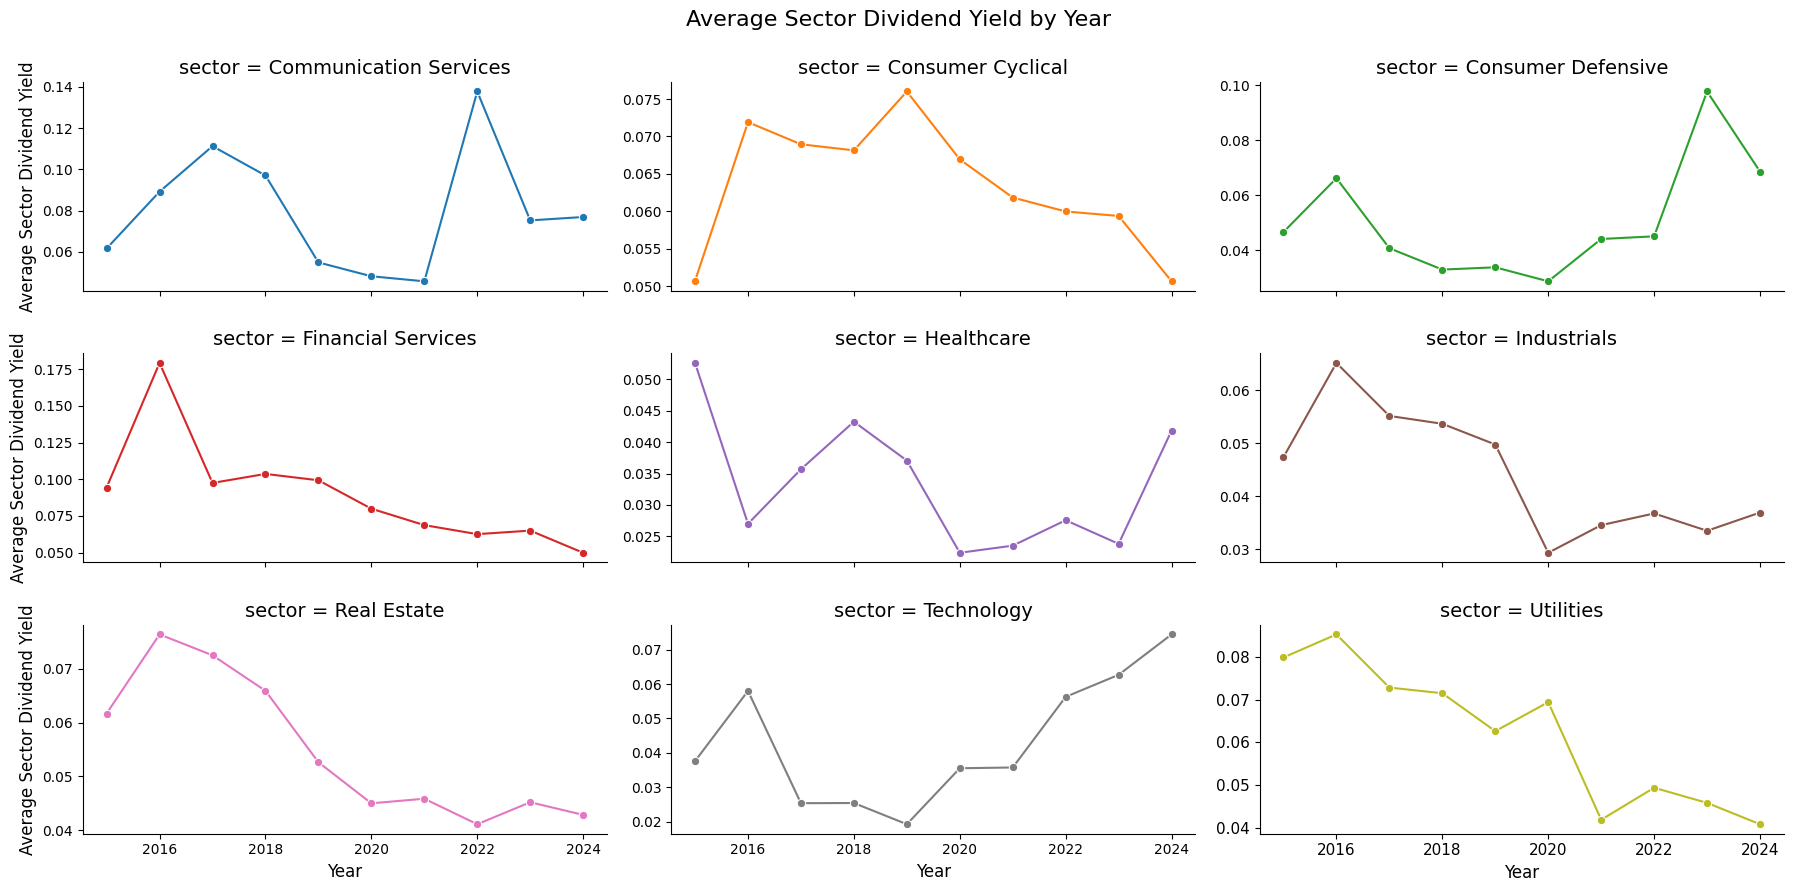

In [34]:
# Create a FacetGrid with vertical stacking (one per row)
g = sns.FacetGrid(sector_avg_dividends_yield_df, col="sector", hue="sector", col_wrap=3, sharey=False, height=3, aspect=2)
g.map(sns.lineplot, "year", "avg_sector_dividend_yield", marker='o')


g.set_axis_labels("Year", "Average Sector Dividend Yield")
g.set_titles("{col_name} Sector")


# Adjust layout and font sizes for readability
plt.subplots_adjust(top=0.85, hspace=0.3)
g.set_xlabels(size=12)
g.set_ylabels(size=12)
g.set_titles(size=14)
g.figure.suptitle('Average Sector Dividend Yield by Year', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.subplots_adjust(top=0.9, hspace=0.3)

plt.show()

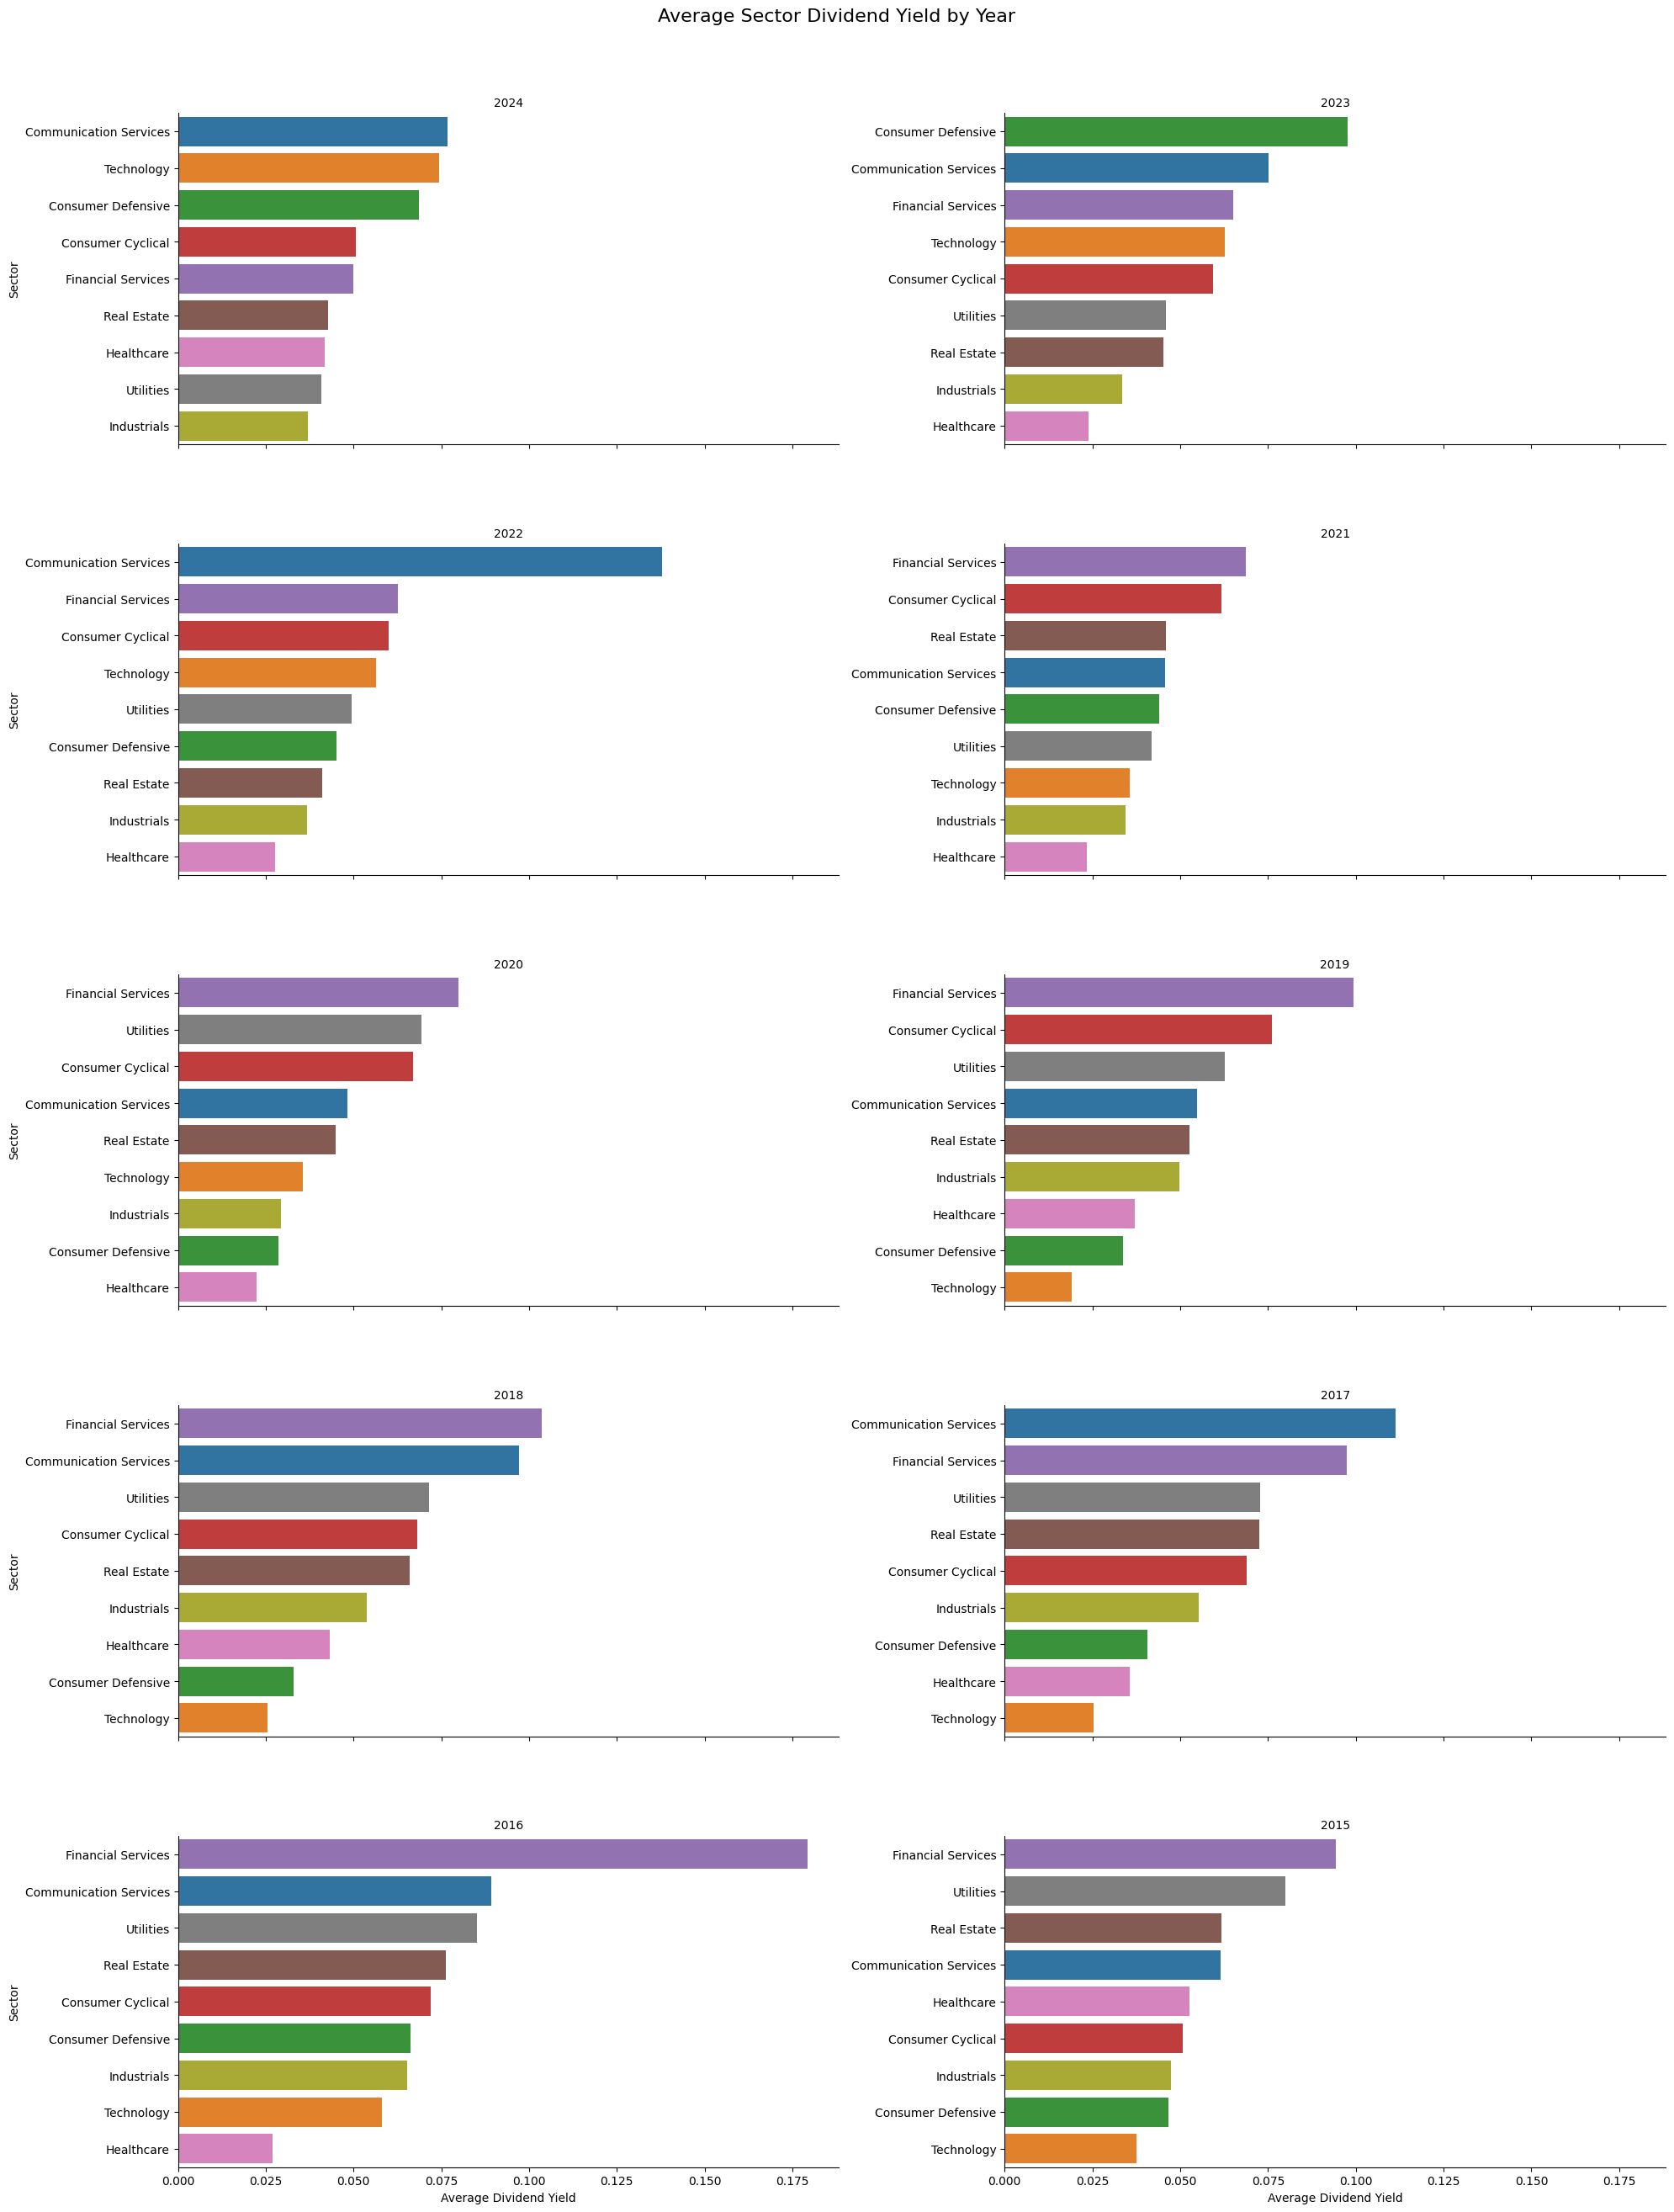

In [35]:
# Create a FacetGrid with vertical stacking (one per row)
# Sort the DataFrame by average dividend yield
sector_avg_dividends_yield_sorted_df = sector_avg_dividends_yield_df.sort_values(by=['year', 'avg_sector_dividend_yield'], ascending=[False, False])


# Use seaborn's catplot for better handling with sorting
g = sns.catplot(data=sector_avg_dividends_yield_sorted_df, 
                kind='bar', 
                x='avg_sector_dividend_yield', y='sector', 
                col='year', hue='sector',col_wrap=2,
                col_order=sector_avg_dividends_yield_sorted_df['year'].unique(), 
                sharey=False, height=5, aspect=2, orient='h')

# Add labels and title
g.set_axis_labels("Average Dividend Yield", "Sector")
g.set_titles("{col_name}")
g.figure.suptitle('Average Sector Dividend Yield by Year', fontsize=16, y=1.05)

# Adjust layout for spacing
plt.subplots_adjust(top=1, hspace=0.3)
plt.show()

In [36]:
sector_avg_dividends_yield_sorted_df['rank'] = sector_avg_dividends_yield_sorted_df.groupby('year')['avg_sector_dividend_yield'].rank(ascending=False)
sector_avg_dividends_yield_sorted_df

,sector,year,avg_sector_dividend_yield,company_count,rank
9,Communication Services,2024,0.076881,Chorus Limited (NS)NZME LimitedSky Network Tel...,1.0
79,Technology,2024,0.074473,Solution Dynamics Limited,2.0
29,Consumer Defensive,2024,0.068595,Comvita LimitedDelegat Group LimitedFonterra C...,3.0
19,Consumer Cyclical,2024,0.050662,2 Cheap Cars Group LimitedBriscoe Group Limite...,4.0
39,Financial Services,2024,0.049935,ANZ Group Holdings LimitedAustralian Foundatio...,5.0
69,Real Estate,2024,0.042864,Argosy Property LimitedCDL Investments New Zea...,6.0
49,Healthcare,2024,0.041849,AFT Pharmaceuticals LimitedEbos Group LimitedF...,7.0
89,Utilities,2024,0.040856,Contact Energy LimitedGenesis Energy Limited (...,8.0
59,Industrials,2024,0.036899,Air New Zealand Limited (NS)Auckland Internati...,9.0
28,Consumer Defensive,2023,0.097741,Comvita LimitedDelegat Group LimitedFonterra C...,1.0


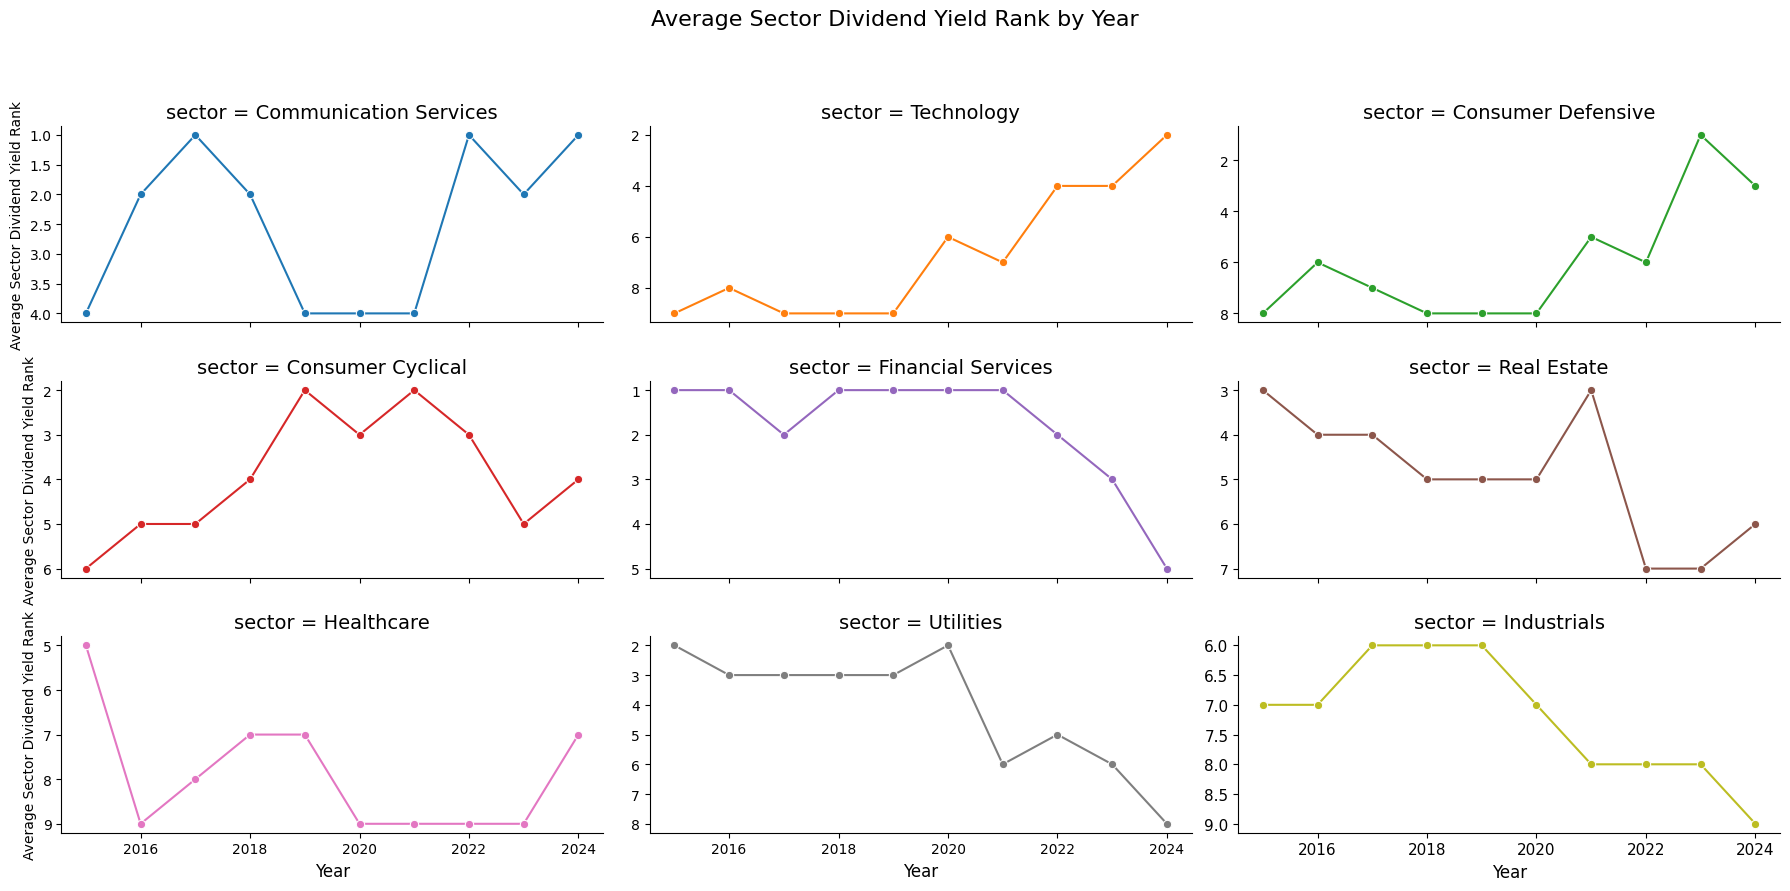

In [37]:
# Create a FacetGrid with vertical stacking (one per row)
g = sns.FacetGrid(sector_avg_dividends_yield_sorted_df, col="sector", hue="sector", col_wrap=3,sharey=False, height=3, aspect=2)
g.map(sns.lineplot, "year", "rank", marker='o')

# Invert the y-axis for rank
for ax in g.axes.flat:
    ax.invert_yaxis()
    
g.set_axis_labels("Year", "Average Sector Dividend Yield Rank")
g.set_titles("{col_name} Sector")


# Adjust layout and font sizes for readability
plt.subplots_adjust(top=0.85, hspace=0.3)
g.set_xlabels(size=12)
g.set_ylabels(size=10)
g.set_titles(size=14)
g.figure.suptitle('Average Sector Dividend Yield Rank by Year', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.show()

In [38]:
annual_dividend_yield[annual_dividend_yield['sector'] == 'Communication Services']

,company,year,annual_dividend,avg_price,sector,annual_yield
106,Chorus Limited (NS),2016,0.200000,2.577363,Communication Services,0.077599
107,Chorus Limited (NS),2017,0.210000,2.804988,Communication Services,0.074867
108,Chorus Limited (NS),2018,0.220000,3.274655,Communication Services,0.067183
109,Chorus Limited (NS),2019,0.230000,4.172616,Communication Services,0.055121
110,Chorus Limited (NS),2020,0.240000,6.203497,Communication Services,0.038688
111,Chorus Limited (NS),2021,0.250000,5.961027,Communication Services,0.041939
112,Chorus Limited (NS),2022,0.350000,6.454459,Communication Services,0.054226
113,Chorus Limited (NS),2023,0.425000,6.862790,Communication Services,0.061928
114,Chorus Limited (NS),2024,0.475000,7.987342,Communication Services,0.059469
115,Chorus Limited (NS),2025,0.230000,7.780000,Communication Services,0.029563


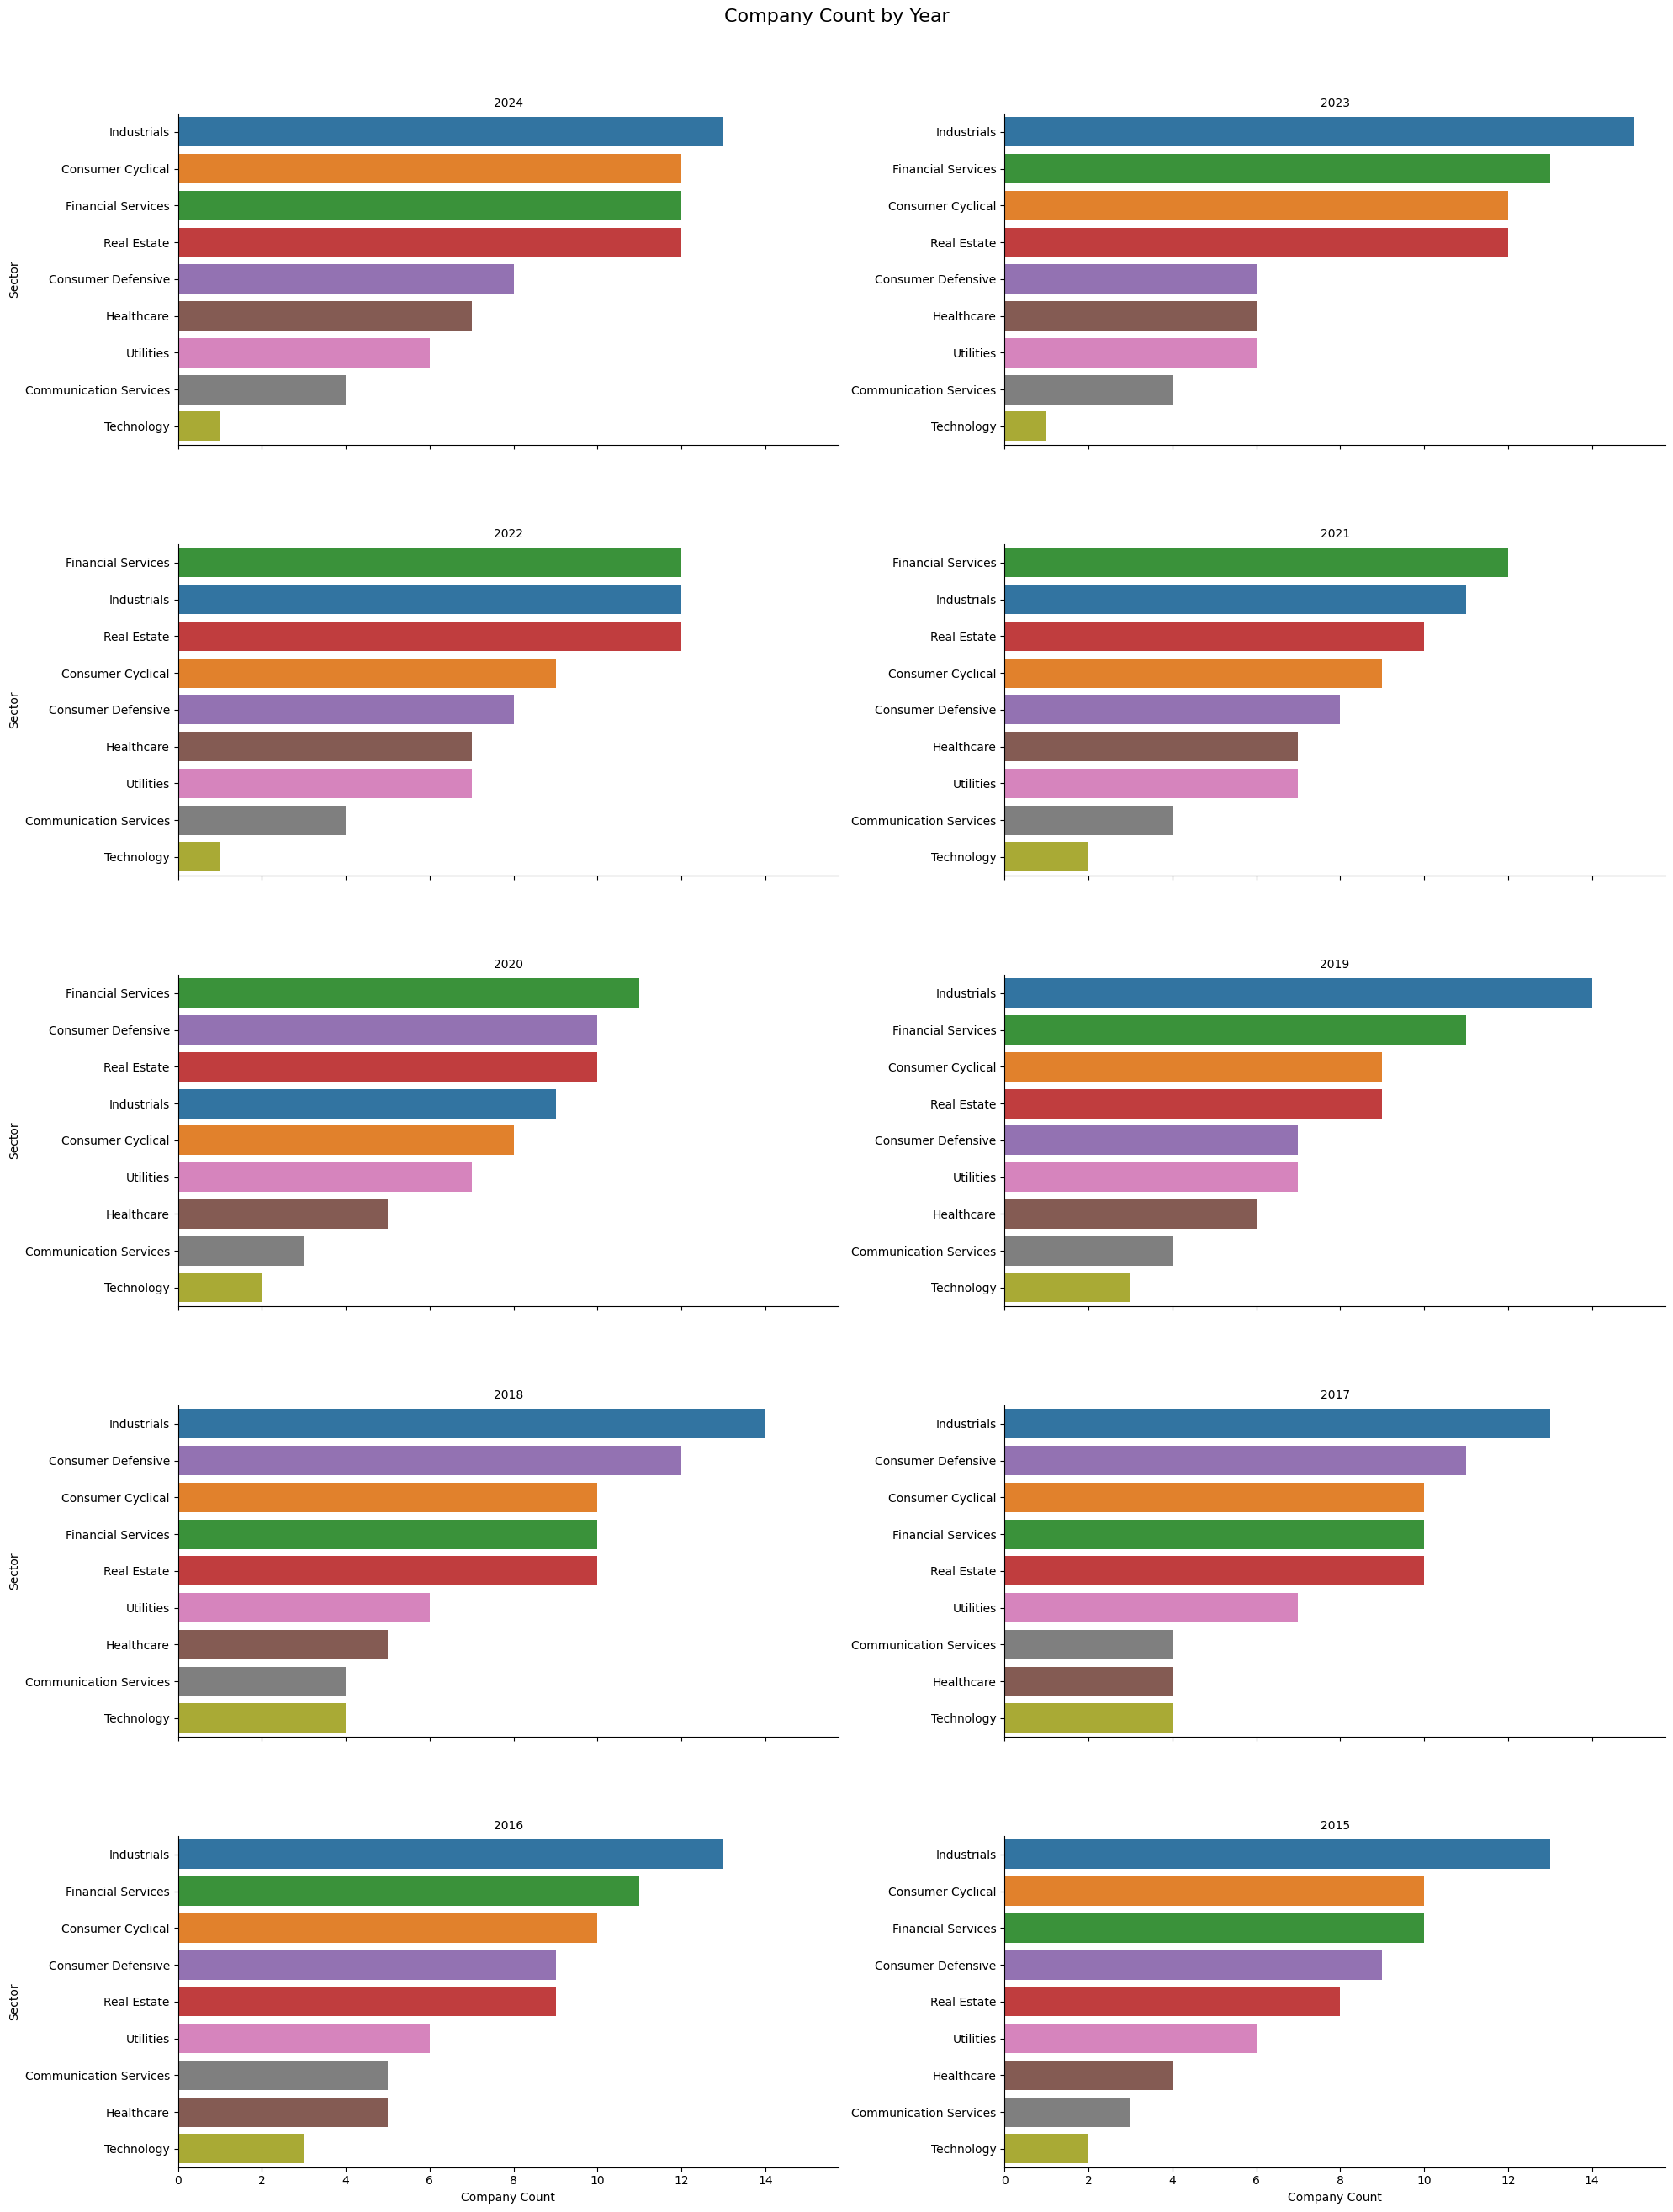

In [46]:
sector_avg_dividends_yield_df = sector_avg_dividends_yield_df.sort_values(by=['year', 'company_count'], ascending=[False, False])

# Use seaborn's catplot for better handling with sorting
g = sns.catplot(data=sector_avg_dividends_yield_df, 
                kind='bar', 
                x='company_count', y='sector', 
                col='year', hue='sector',col_wrap=2,
                col_order=sector_avg_dividends_yield_df['year'].unique(), 
                sharey=False, height=5, aspect=2, orient='h')

# Add labels and title
g.set_axis_labels("Company Count", "Sector")
g.set_titles("{col_name}")
g.figure.suptitle('Company Count by Year', fontsize=16, y=1.05)

# Adjust layout for spacing
plt.subplots_adjust(top=1, hspace=0.3)
plt.show()